In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
facebook_data = pd.read_csv("C:\\Users\\Hp\\Desktop\\future_interns\\facebookdata\\data.csv")

In [3]:
facebook_data.head()

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,17/08/2017,17/08/2017,916,103916,30-34,M,15,17,17,7350.0,1,1.43,2.0,1.0
1,708749,17/08/2017,17/08/2017,916,103917,30-34,M,16,19,21,17861.0,2,1.82,2.0,0.0
2,708771,17/08/2017,17/08/2017,916,103920,30-34,M,20,25,22,693.0,0,0.00,1.0,0.0
3,708815,30/08/2017,30/08/2017,916,103928,30-34,M,28,32,32,4259.0,1,1.25,1.0,0.0
4,708818,17/08/2017,17/08/2017,916,103928,30-34,M,28,33,32,4133.0,1,1.29,1.0,1.0


In [4]:
for col in ['reporting_start', 'reporting_end']:
    facebook_data[col] = pd.to_datetime(facebook_data[col], format='%d/%m/%Y', errors='coerce')

num_cols = ['impressions', 'clicks', 'spent', 'total_conversion', 'approved_conversion']
for c in num_cols:
    facebook_data[c] = pd.to_numeric(facebook_data[c], errors='coerce')


In [5]:
# 3) Derive metrics
# Avoid divide-by-zero
facebook_data['ctr'] = np.where(facebook_data['impressions'] > 0, facebook_data['clicks'] / facebook_data['impressions'], np.nan)
# Engagement proxy: clicks + total conversions (if available)
facebook_data['engagement'] = facebook_data['clicks'].fillna(0) + facebook_data['total_conversion'].fillna(0)
# CPA and CPC
facebook_data['cpc'] = np.where(facebook_data['clicks'] > 0, facebook_data['spent'] / facebook_data['clicks'], np.nan)
facebook_data['cpa_total'] = np.where(facebook_data['total_conversion'] > 0, facebook_data['spent'] / facebook_data['total_conversion'], np.nan)
facebook_data['cpa_approved'] = np.where(facebook_data['approved_conversion'] > 0, facebook_data['spent'] / facebook_data['approved_conversion'], np.nan)


In [6]:
value_per_approved = 10.0
facebook_data['revenue_proxy'] = facebook_data['approved_conversion'].fillna(0) * value_per_approved
facebook_data['roi_proxy'] = np.where(facebook_data['spent'] > 0, (facebook_data['revenue_proxy'] - facebook_data['spent']) / facebook_data['spent'], np.nan)


In [7]:
agg_cols = {
    'impressions': 'sum',
    'clicks': 'sum',
    'spent': 'sum',
    'total_conversion': 'sum',
    'approved_conversion': 'sum'
}


In [8]:
camp = facebook_data.groupby('campaign_id').agg(agg_cols).reset_index()
camp.head()

,campaign_id,impressions,clicks,spent,total_conversion,approved_conversion
0,1178,6.990248e+07,9577,16577.159998,1050.0,378.0
1,30-34,7.559180e+03,541,166.000000,0.0,0.0
2,35-39,5.966910e+03,269,78.000000,0.0,0.0
3,40-44,7.252100e+03,288,88.000000,0.0,0.0
4,45-49,1.830680e+04,521,162.000000,0.0,0.0


In [9]:
camp['ctr'] = np.where(camp['impressions'] > 0, camp['clicks'] / camp['impressions'], np.nan)
camp['cpc'] = np.where(camp['clicks'] > 0, camp['spent'] / camp['clicks'], np.nan)
camp['cpa_total'] = np.where(camp['total_conversion'] > 0, camp['spent'] / camp['total_conversion'], np.nan)
camp['cpa_approved'] = np.where(camp['approved_conversion'] > 0, camp['spent'] / camp['approved_conversion'], np.nan)
camp['revenue_proxy'] = camp['approved_conversion'] * value_per_approved
camp['roi_proxy'] = np.where(camp['spent'] > 0, (camp['revenue_proxy'] - camp['spent']) / camp['spent'], np.nan)

print('Aggregated by campaign_id:')
print(camp.head())

Aggregated by campaign_id:
  campaign_id   impressions  clicks         spent  total_conversion  \
0        1178  6.990248e+07    9577  16577.159998            1050.0   
1       30-34  7.559180e+03     541    166.000000               0.0   
2       35-39  5.966910e+03     269     78.000000               0.0   
3       40-44  7.252100e+03     288     88.000000               0.0   
4       45-49  1.830680e+04     521    162.000000               0.0   

   approved_conversion       ctr       cpc  cpa_total  cpa_approved  \
0                378.0  0.000137  1.730935  15.787771     43.854921   
1                  0.0  0.071569  0.306839        NaN           NaN   
2                  0.0  0.045082  0.289963        NaN           NaN   
3                  0.0  0.039713  0.305556        NaN           NaN   
4                  0.0  0.028459  0.310940        NaN           NaN   

   revenue_proxy  roi_proxy  
0         3780.0  -0.771975  
1            0.0  -1.000000  
2            0.0  -1.000000  

In [10]:
# 6) Top posts (ads) by engagement and CTR
ads_sorted_eng =facebook_data.sort_values(['engagement', 'clicks', 'total_conversion'], ascending=[False, False, False]).head(10)
ads_sorted_ctr = facebook_data[facebook_data['impressions'] > 100].sort_values('ctr', ascending=False).head(10)

print('Top 5 ads by engagement:')
print(ads_sorted_eng[['ad_id','impressions','clicks','total_conversion','approved_conversion','engagement','ctr','spent']].head())
print('Top 5 ads by CTR (min 100 impressions):')
print(ads_sorted_ctr[['ad_id','impressions','clicks','ctr','spent']].head())

Top 5 ads by engagement:
       ad_id  impressions  clicks  total_conversion  approved_conversion  \
525  1121100    3052003.0     340              60.0                 17.0   
662  1121367    1447755.0     233              11.0                  8.0   
528  1121104    2080666.0     202              40.0                 21.0   
574  1121196    1392288.0     206              31.0                  7.0   
760  1121593    1177535.0     221              15.0                  3.0   

     engagement       ctr       spent  
525       400.0  0.000111  639.949998  
662       244.0  0.000161  420.579998  
528       242.0  0.000097  360.150001  
574       237.0  0.000148  358.550003  
760       236.0  0.000188  365.660001  
Top 5 ads by CTR (min 100 impressions):
        ad_id  impressions  clicks       ctr  spent
1094  1314360   110.780002      21  0.189565    2.0
1097  1314363   119.640002      20  0.167168    4.0
1101  1314367   163.800000      23  0.140415    9.0
1116  1314387   223.189995    

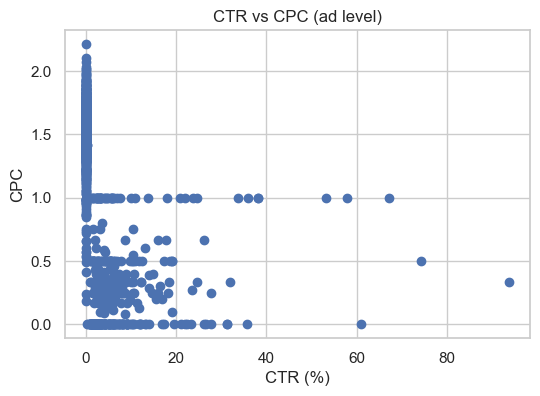

In [11]:
# 7) Visuals: CTR vs CPC scatter, and conversions vs spend
sns.set(style='whitegrid')
plt.figure(figsize=(6,4))
plt.scatter(facebook_data['ctr']*100,facebook_data['cpc'])
plt.xlabel('CTR (%)')
plt.ylabel('CPC')
plt.title('CTR vs CPC (ad level)')
plt.show()



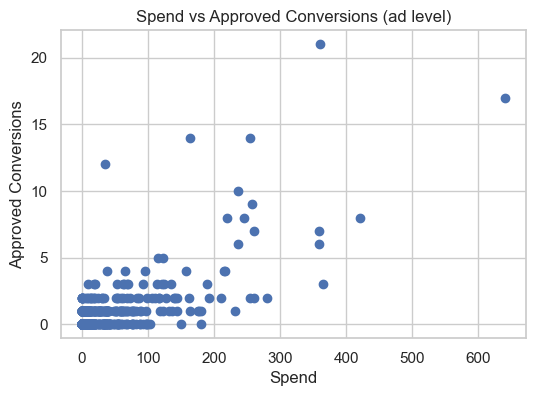

In [12]:
plt.figure(figsize=(6,4))
plt.scatter(facebook_data['spent'], facebook_data['approved_conversion'])
plt.xlabel('Spend')
plt.ylabel('Approved Conversions')
plt.title('Spend vs Approved Conversions (ad level)')
plt.show()

In [13]:
# 8) Summaries for recommendations
overall = facebook_data.agg(agg_cols)
overall['ctr'] = overall['clicks'] / overall['impressions'] if overall['impressions'] > 0 else np.nan
overall['cpc'] = overall['spent'] / overall['clicks'] if overall['clicks'] > 0 else np.nan
overall['cpa_total'] = overall['spent'] / overall['total_conversion'] if overall['total_conversion'] > 0 else np.nan
overall['cpa_approved'] = overall['spent'] / overall['approved_conversion'] if overall['approved_conversion'] > 0 else np.nan
overall['revenue_proxy'] = overall['approved_conversion'] * value_per_approved
overall['roi_proxy'] = (overall['revenue_proxy'] - overall['spent']) / overall['spent'] if overall['spent'] > 0 else np.nan

print('Overall summary:')
print(overall)

Overall summary:
impressions            7.855267e+07
clicks                 1.329300e+04
spent                  2.011424e+04
total_conversion       1.645000e+03
approved_conversion    5.850000e+02
ctr                    1.692240e-04
cpc                    1.513145e+00
cpa_total              1.222750e+01
cpa_approved           3.438332e+01
revenue_proxy          5.850000e+03
roi_proxy             -7.091613e-01
dtype: float64
